# Import needed packages

In [1]:
import numpy as np
from scipy.sparse.linalg import expm_multiply
import matplotlib.pyplot as plt
from seaborn import set_context
set_context('talk')

from pyQME.spectral_density import SpectralDensity
from pyQME.linear_spectra import LinearSpectraCalculator
from pyQME.tensors import RedfieldForsterTensorReal
from pyQME.utils import overdamped_brownian,underdamped_brownian,get_timeaxis,wn2ips,partition_by_clusters

# Define the system

**Hamiltonian (1/cm)**

In [2]:
nchrom = 3 #numero di cromofori

E0 = 10000
energy_gap = 100
coupling_12 = 100
coupling_23 = 30
coupling_13 = 10
H = np.zeros((nchrom,nchrom)) #hamiltonian

H[0] = np.asarray([E0          , coupling_12     , coupling_13     ])
H[1] = np.asarray([coupling_12 , E0+energy_gap   , coupling_23     ])
H[2] = np.asarray([coupling_13 , coupling_23     , E0+2*energy_gap ])

In [3]:
H

array([[1.00e+04, 1.00e+02, 1.00e+01],
       [1.00e+02, 1.01e+04, 3.00e+01],
       [1.00e+01, 3.00e+01, 1.02e+04]])

**Partitioning of the Hamiltonian**

In [4]:
H_part,V = partition_by_clusters(H,cluster_list=[[0,1],[2]])

In [5]:
H_part

array([[10000.,   100.,     0.],
       [  100., 10100.,     0.],
       [    0.,     0., 10200.]])

In [6]:
V

array([[ 0.,  0., 10.],
       [ 0.,  0., 30.],
       [10., 30.,  0.]])

**Temperature (Kelvin)**

In [8]:
temp = 298

**Spectral density**

In [9]:
freq_axis_SD = np.arange(0.1,4000,0.1)

In [10]:
SD_data = overdamped_brownian(freq_axis_SD,30,37)
SD_data = SD_data + underdamped_brownian(freq_axis_SD,5,50,1000)

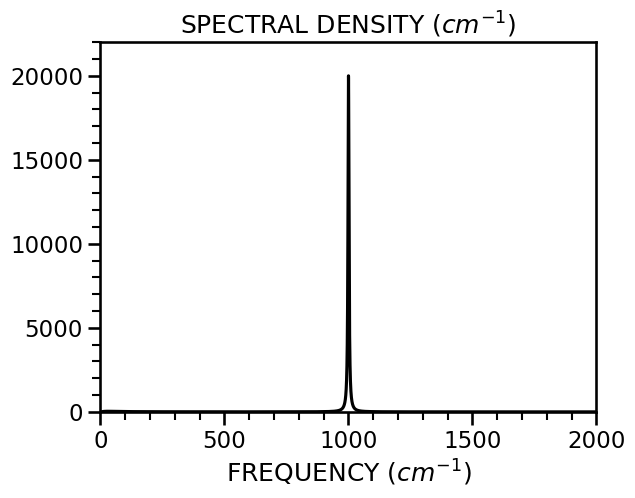

In [11]:
plt.plot(freq_axis_SD,SD_data,color='black');
plt.xlim(0,2000);
plt.ylim(0,22000)
plt.title('SPECTRAL DENSITY ($cm^{-1}$)');
plt.xlabel('FREQUENCY ($cm^{-1}$)');
plt.minorticks_on()

In [12]:
SD_obj = SpectralDensity(freq_axis_SD,SD_data,temperature=temp)

**Time axis (cm)**

In [13]:
energies = np.diag(H)
time_axis = get_timeaxis(SD_obj.Reorg,energies,5)
SD_obj.time = time_axis

**Relaxation Tensor**

In [14]:
rel_tens_obj = RedfieldForsterTensorReal(H_part,V,SD_obj)

# Excited state dynamics

**Time axis**

In [15]:
time_axis_ps = np.arange(0,3,0.001)
time_axis_cm = time_axis_ps*wn2ips

**Initial density matrix**

In [16]:
#site basis
rho_0 = np.zeros([nchrom,nchrom])
rho_0[1,1] = 1.
rho_0[0,1] = rho_0[0,1]

#convert to exciton basis
rho_0_exc = rel_tens_obj.transform(rho_0)

**Propagate**

In [17]:
rho_t_exc = rel_tens_obj.propagate(rho_0_exc,time_axis_cm)

#convert to site basis
rho_t_site = rel_tens_obj.transform_back(rho_t_exc)

# Check the results

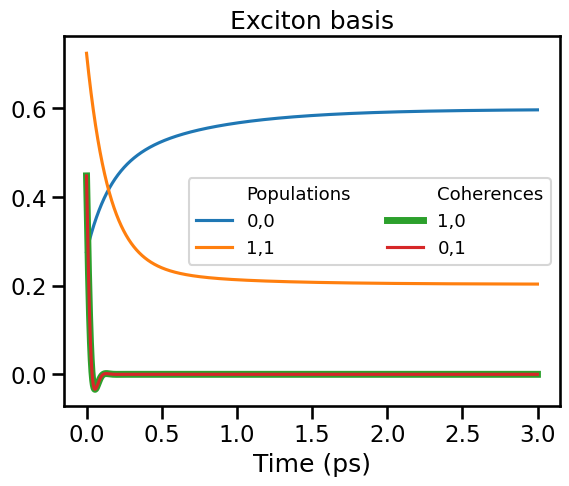

In [18]:
# When using Forster theory, the only possible difference between site and exciton basis is the order of the states

plt.title('Exciton basis')
plt.plot([],[],color='white',label='Populations')
plt.plot(time_axis_ps,rho_t_exc[:,0,0].real,label = '0,0')
plt.plot(time_axis_ps,rho_t_exc[:,1,1].real,label = '1,1')
plt.plot([],[],color='white',label='Coherences')
plt.plot(time_axis_ps,rho_t_exc[:,1,0].real,label = '1,0',lw=5)
plt.plot(time_axis_ps,rho_t_exc[:,0,1].real,label = '0,1')
plt.legend(ncol=2,fontsize = 13)
plt.xlabel('Time (ps)');

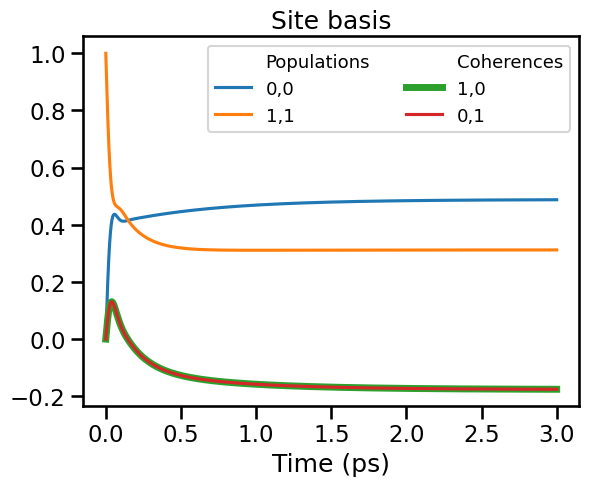

In [19]:
plt.title('Site basis')
plt.plot([],[],color='white',label='Populations')
plt.plot(time_axis_ps,rho_t_site[:,0,0].real,label = '0,0')
plt.plot(time_axis_ps,rho_t_site[:,1,1].real,label = '1,1')
plt.plot([],[],color='white',label='Coherences')
plt.plot(time_axis_ps,rho_t_site[:,1,0].real,label = '1,0',lw=5)
plt.plot(time_axis_ps,rho_t_site[:,0,1].real,label = '0,1')
plt.legend(ncol=2,fontsize = 13)
plt.xlabel('Time (ps)');